# AR5IR RCMIP

Here we perform the AR5IR runs for RCMIP. This notebook shows how the OpenSCM library should 'feel' to the end user. We're not at that point yet and will need a major re-write to get it workable, but this at least shows where we're going.

## Imports

In [16]:
import json
import os.path

import numpy as np
import pandas as pd
import tqdm.notebook
from scmdata import df_append, ScmDataFrame

## Models

In [2]:
class AR5IRBase():
    def __init__(self):
        pass

    def run(self, inputs, run_params, outputs=None):
        """
        inputs : scmdata.ScmDataFrame
        
        run_params : dict
        """
        if outputs is not None and outputs != ["Surface Temperature"]:
            print(outputs)
            raise ValueError("{} only calculates Surface Temperature".format(self.name))
    
        co2_concentrations_scmdf = inputs.filter(
            variable="Atmospheric Concentrations|CO2",
            region="World",
            unit="ppm",
        )
        
        scenario = co2_concentrations_scmdf.get_unique_meta("scenario", no_duplicates=True)
        model = co2_concentrations_scmdf.get_unique_meta("model", no_duplicates=True)
        time = co2_concentrations_scmdf["time"]
        
        self.co2_concentrations = co2_concentrations_scmdf.timeseries().values.squeeze()
        non_co2_radiative_forcing_scmdf = inputs.filter(
            variable="Effective Radiative Forcing|Non-CO2",
            region="World",
            unit="W/m\^2",
        )
        if non_co2_radiative_forcing_scmdf.timeseries().empty:
            self.non_co2_radiative_forcing = np.zeros_like(self.co2_concentrations)
            
            non_co2_radiative_forcing_scmdf = self._create_out_scmdf(
                "Effective Radiative Forcing|Non-CO2",
                "W/m^2",
                np.zeros_like(self.co2_concentrations),
                co2_concentrations_scmdf,
            )
        else:
            self.non_co2_radiative_forcing = non_co2_radiative_forcing_scmdf.timeseries().values.squeeze()
            
        assert self.co2_concentrations.shape == self.non_co2_radiative_forcing.shape, (
            "{}, {}".format(self.co2_concentrations.shape, self.non_co2_radiative_forcing.shape)
        )
        for kwarg, value in run_params.items():
            setattr(self, kwarg, value)

        self.calculate_co2_radiative_forcing()
        self.calculate_temperatures()
        
        out_temperatures = self._create_out_scmdf(
            "Surface Air Temperature Change",
            "K",
            self.temperatures,
            co2_concentrations_scmdf,
        )
        
        out_co2_forcing = self._create_out_scmdf(
            "Effective Radiative Forcing|CO2",
            "W/m^2",
            self.co2_radiative_forcing,
            co2_concentrations_scmdf,
        )
        
        out = df_append([
            co2_concentrations_scmdf, 
            non_co2_radiative_forcing_scmdf, 
            out_temperatures, 
            out_co2_forcing,
        ])
        out.set_meta(self.name, "climatemodel")

        return out
    
    def _create_out_scmdf(self, variable, unit, values, base_scmdf):
        out_scmdf = base_scmdf.timeseries()
        out_scmdf.iloc[:, :] = values
        out_scmdf = out_scmdf.reset_index()
        out_scmdf["variable"] = variable
        out_scmdf["unit"] = unit
        
        return ScmDataFrame(out_scmdf)

    def calculate_co2_radiative_forcing(self):
        self.co2_radiative_forcing = (
            self.f2x / np.log(2) * np.log(self.co2_concentrations / self.co2_pi)
        )

In [3]:
class AR5IR2Box(AR5IRBase):
    """
    Quick implementation of AR5IR in a CO2-conc plus non-CO2 ERF driven run mode
    
    Based on:
    F = F2x / ln(2) * ln(C / C_0)
    
    where F2x is RF due to doubling CO2, C is atmospheric conc. of CO2 
    and C_0 is PI conc. of CO2
    
    c_j F = \\Delta T + d_j d \\Delta T / dt 
    
    with j=2 and all terms as in IPCC AR5 WG1 eq. 8.SM.13
    
    Inputs should all be on an annual timestep (no checks are done for
    this...)
    """

    name = "ar5ir2box"

    co2_pi = 278
    f2x = 3.74
    c1 = 0.631
    d1 = 8.4
    c2 = 0.429
    d2 = 409.5

    def calculate_temperatures(self):
        """
        This is a bit fiddly as we have to return mid year values
        """
        c = np.array([self.c1, self.c2])
        d = np.array([self.d1, self.d2])
        temp_perturbations = np.nan * np.zeros((len(self.co2_concentrations) + 1, 2))
        temp_perturbations[0, :] = 0

        factor = 1 - 1 / d
        total_forcing = self.co2_radiative_forcing + self.non_co2_radiative_forcing
        temp = total_forcing[:, np.newaxis] * c / d
        for i in range(1, temp_perturbations.shape[0]):
            temp_perturbations[i, :] = (
                temp_perturbations[i - 1] * factor + temp[i - 1]
            )  # assuming one year timestep

        temp_perturbations_midyear = (
            temp_perturbations[:-1, :] + temp_perturbations[1:, :]
        ) / 2
        self.temperatures = temp_perturbations_midyear.sum(axis=1)

In [4]:
class AR5IR3Box(AR5IRBase):
    """
    Quick implementation of AR5IR with 3 boxes in a CO2-conc plus non-CO2 ERF driven run mode
    
    Based on:
    F = F2x / ln(2) * ln(C / C_0)
    
    where F2x is RF due to doubling CO2, C is atmospheric conc. of CO2 
    and C_0 is PI conc. of CO2
    
    c_j F = \\Delta T + d_j d \\Delta T / dt 
    
    with j=3 and all terms as in IPCC AR5 WG1 eq. 8.SM.13
    
    Inputs should all be on an annual timestep (no checks are done for
    this...)
    """

    name = "ar5ir3box"

    co2_pi = 278
    f2x = 3.74
    c1 = 0.631
    d1 = 8.4
    c2 = 0.429
    d2 = 409.5
    c3 = 0.2
    d3 = 1

    def calculate_temperatures(self):
        """
        This is a bit fiddly as we have to return mid year values
        """
        c = np.array([self.c1, self.c2, self.c3])
        d = np.array([self.d1, self.d2, self.d3])
        temp_perturbations = np.nan * np.zeros((len(self.co2_concentrations) + 1, 3))
        temp_perturbations[0, :] = 0

        factor = 1 - 1 / d
        total_forcing = self.co2_radiative_forcing + self.non_co2_radiative_forcing
        temp = total_forcing[:, np.newaxis] * c / d
        for i in range(1, temp_perturbations.shape[0]):
            temp_perturbations[i, :] = (
                temp_perturbations[i - 1] * factor + temp[i - 1]
            )  # assuming one year timestep

        temp_perturbations_midyear = (
            temp_perturbations[:-1, :] + temp_perturbations[1:, :]
        ) / 2
        self.temperatures = temp_perturbations_midyear.sum(axis=1)

## RCMIP data

In [5]:
RCMIP_CONCS_FILE = os.path.join(
    "rcmip-concentrations-annual-means-v3-1-0.csv"
)

RCMIP_FORCING_FILE = os.path.join(
    "rcmip-radiative-forcing-annual-means-v3-1-0.csv"
)

In [6]:
rcmip_data = df_append([RCMIP_CONCS_FILE, RCMIP_FORCING_FILE])
rcmip_data.head()

,,,,,,time,1700-01-01 00:00:00,1701-01-01 00:00:00,1702-01-01 00:00:00,1703-01-01 00:00:00,1704-01-01 00:00:00,1705-01-01 00:00:00,1706-01-01 00:00:00,1707-01-01 00:00:00,1708-01-01 00:00:00,1709-01-01 00:00:00,...,2491-01-01 00:00:00,2492-01-01 00:00:00,2493-01-01 00:00:00,2494-01-01 00:00:00,2495-01-01 00:00:00,2496-01-01 00:00:00,2497-01-01 00:00:00,2498-01-01 00:00:00,2499-01-01 00:00:00,2500-01-01 00:00:00
model,scenario,region,variable,unit,activity_id,mip_era,,,,,,,,,,,,,,,,,,,,,
AIM,rcp60,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1510.758900,1510.758900,1510.75890,1510.758900,1510.758900,1510.75890,1510.75890,1510.758900,1510.758900,1510.758900
IMAGE,rcp26,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1266.721139,1266.844724,1266.96669,1267.044469,1267.056545,1267.03375,1267.00571,1266.997029,1267.024136,1267.051079
MESSAGE,rcp85,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3481.180700,3481.180700,3481.18070,3481.180700,3481.180700,3481.18070,3481.18070,3481.180700,3481.180700,3481.180700
MiniCAM,rcp45,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1541.647100,1541.647100,1541.64710,1541.647100,1541.647100,1541.64710,1541.64710,1541.647100,1541.647100,1541.647100
unspecified,historical-cmip5,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
co2_conc_0 = (
    rcmip_data.filter(
        variable="Atmospheric Concentrations|CO2",
        region="World",
        scenario="abrupt-2xCO2",
        year=1900,
    ).values.squeeze()
    / 2
)
co2_conc_0

284.31699879964185

Calculate non-CO2 effective radiative forcing.

In [8]:
erf_filter = "Effective Radiative Forcing*"
rcmip_erfs = rcmip_data.filter(
    variable=erf_filter
).timeseries().unstack("variable").stack("time")

rcmip_erfs["Effective Radiative Forcing|Non-CO2"] = (
    rcmip_erfs["Effective Radiative Forcing"] 
    - rcmip_erfs["Effective Radiative Forcing|Anthropogenic|CO2"]
)
rcmip_erfs = rcmip_erfs.unstack("time").stack("variable")
rcmip_data = rcmip_data.filter(variable=erf_filter, keep=False).append(rcmip_erfs)
rcmip_data.head()

,,,,,,time,1700-01-01 00:00:00,1701-01-01 00:00:00,1702-01-01 00:00:00,1703-01-01 00:00:00,1704-01-01 00:00:00,1705-01-01 00:00:00,1706-01-01 00:00:00,1707-01-01 00:00:00,1708-01-01 00:00:00,1709-01-01 00:00:00,...,2491-01-01 00:00:00,2492-01-01 00:00:00,2493-01-01 00:00:00,2494-01-01 00:00:00,2495-01-01 00:00:00,2496-01-01 00:00:00,2497-01-01 00:00:00,2498-01-01 00:00:00,2499-01-01 00:00:00,2500-01-01 00:00:00
model,scenario,region,variable,unit,activity_id,mip_era,,,,,,,,,,,,,,,,,,,,,
AIM,rcp60,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1510.758900,1510.758900,1510.75890,1510.758900,1510.758900,1510.75890,1510.75890,1510.758900,1510.758900,1510.758900
IMAGE,rcp26,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1266.721139,1266.844724,1266.96669,1267.044469,1267.056545,1267.03375,1267.00571,1266.997029,1267.024136,1267.051079
MESSAGE,rcp85,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3481.180700,3481.180700,3481.18070,3481.180700,3481.180700,3481.18070,3481.18070,3481.180700,3481.180700,3481.180700
MiniCAM,rcp45,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1541.647100,1541.647100,1541.64710,1541.647100,1541.647100,1541.64710,1541.64710,1541.647100,1541.647100,1541.647100
unspecified,historical-cmip5,World,Atmospheric Concentrations|CH4,ppb,input4MIPs,CMIP5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
rcmip_data.filter(variable="Effective Radiative Forcing|Non-CO2").head()

time                                                                                            1750-01-01 00:00:00  \
model   scenario       region variable                            unit  activity_id    mip_era                        
AIM/CGE ssp370         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
        ssp370-lowNTCF World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
GCAM4   ssp434         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
        ssp460         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   
IMAGE   ssp119         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.259367   

time                                                                                            1751-01-01 00:00:00  \
model   scenario       region variable                            unit  activity_id    mip_era                        
AIM/CGE ssp370         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
        ssp370-lowNTCF World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
GCAM4   ssp434         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
        ssp460         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   
IMAGE   ssp119         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.241965   

time                                                                                            1752-01-01 00:00:00  \
model   scenario       region variable                            unit  activity_id    mip_era                        
AIM/CGE ssp370         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
        ssp370-lowNTCF World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
GCAM4   ssp434         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
        ssp460         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   
IMAGE   ssp119         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.213009   

time                                                                                            1753-01-01 00:00:00  \
model   scenario       region variable                            unit  activity_id    mip_era                        
AIM/CGE ssp370         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
        ssp370-lowNTCF World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
GCAM4   ssp434         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
        ssp460         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   
IMAGE   ssp119         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.177158   

time                                                                                            1754-01-01 00:00:00  \
model   scenario       region variable                            unit  activity_id    mip_era                        
AIM/CGE ssp370         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
        ssp370-lowNTCF World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
GCAM4   ssp434         World  Effective Radiative Forcing|Non-CO2 W/m^2 not_applicable CMIP6               0.142201   
        ssp460         World  Effective Radiative Forcing|Non-CO2 W/m

## Run

In [102]:
with open("ar5ir2box-cfgs.json", "r") as fh:
    ar5ir2box_cfgs = json.load(fh)
    
ar5ir2box_cfgs[:2]

[{'descr': 'AR5IR (Ch. 8 SM) calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-CSM2-MR model',
  'name': 'ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB',
  'parameter_values': {'c1': 0.4395185057788764,
   'c2': 1.6600176932094155,
   'd1': 4.226911772914753,
   'd2': 1214.967819659438,
   'f2x': 4.186548271315887}},
 {'descr': 'AR5IR (Ch. 8 SM) calibrated to the idealised CO2-only experiments for the r1i1p1f1 variant of the BCC-ESM1 model',
  'name': 'ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB',
  'parameter_values': {'c1': 0.38619637106259846,
   'c2': 0.8812223827952353,
   'd1': 5.271898475097845,
   'd2': 669.2868008327575,
   'f2x': 4.583646459185962}}]

In [ ]:
with open("ar5ir3box-cfgs.json", "r") as fh:
    ar5ir3box_cfgs = json.load(fh)
    
ar5ir3box_cfgs[:2]

In [114]:
import warnings
warnings.filterwarnings("ignore")

runners_cfgs = {AR5IR2Box: ar5ir2box_cfgs, AR5IR3Box: ar5ir3box_cfgs}

results = []
for runner, cfgs in tqdm.notebook.tqdm(runners_cfgs.items(), desc="Model"):
    runner = model()
    runner.co2_pi = co2_conc_0
    startyear=1750
    endyear=2500
    scens_to_run = rcmip_data.filter(
        variable="Atmospheric Concentrations|CO2"
    ).filter(
        mip_era="CMIP6"  # we don't have ERF for CMIP5 stuff...
    )["scenario"].unique()
    for scenario in tqdm.notebook.tqdm(scens_to_run, desc="scenarios", leave=False):
        run_df = rcmip_data.filter(scenario=scenario, year=range(startyear, endyear+1))
        for cfg in tqdm.notebook.tqdm(cfgs, desc="configs", leave=False):
            pvs = cfg["parameter_values"]
            res_run = runner.run(run_df, pvs)
            res_run.set_meta(cfg["name"], "climatemodel")
            
            ecs = pvs["f2x"] * (pvs["c1"] + pvs["c2"])
            res_run.set_meta(ecs, "ECS (K)")
            
            tcr = pvs["f2x"] * (
                (pvs["c1"] * (1 - (pvs["d1"] / 70) * (1 - np.exp(-70 / pvs["d1"]))))
                + (pvs["c2"] * (1 - (pvs["d2"] / 70) * (1 - np.exp(-70 / pvs["d2"]))))
            )
            res_run.set_meta(tcr, "TCR (K)")
            
            results.append(res_run)
            
results = df_append(results)

Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!
Filtered ScmDataFrame is empty!


In [115]:
results.filter(scenario="1pctCO2", variable="*Temperature*").timeseries()

time                                                                                                                                                 1850-01-01 00:00:00  \
model       scenario region variable                       unit ECS (K)   TCR (K)  activity_id climatemodel                                 mip_era                        
unspecified 1pctCO2  World  Surface Air Temperature Change K    5.809399  1.840923 input4MIPs  ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB      CMIP6                    0.0   
                                                                5.856884  1.909646 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                7.507616  2.236029 input4MIPs  ar5ir2box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB   CMIP6                    0.0   
                                                                7.509541  2.510559 input4MIPs  ar5ir2box-CMIP6-IPSL-CM6A-LR_r1i1p1f1-CALIB  CMIP6                    0.0   
                                                                7.876783  1.733024 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                8.084336  2.399584 input4MIPs  ar5ir2box-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB    CMIP6                    0.0   
                                                                8.789810  1.925368 input4MIPs  ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB   CMIP6                    0.0   
                                                                9.441437  2.782191 input4MIPs  ar5ir2box-CMIP6-UKESM1-0-LL_r1i1p1f2-CALIB   CMIP6                    0.0   
                                                                15.828432 1.847286 input4MIPs  ar5ir2box-CMIP6-MPI-ESM1-2-HR_r1i1p1f1-CALIB CMIP6                    0.0   
                                                                19.580475 2.857156 input4MIPs  ar5ir2box-CMIP6-CanESM5_r1i1p1f1-CALIB       CMIP6                    0.0   
                                                                31.783403 2.553123 input4MIPs  ar5ir2box-CMIP6-EC-Earth3-Veg_r1i1p1f1-CALIB CMIP6                    0.0   

time                                                                                                                                                 1851-01-01 00:00:00  \
model       scenario region variable                       unit ECS (K)   TCR (K)  activity_id climatemodel                                 mip_era                        
unspecified 1pctCO2  World  Surface Air Temperature Change K    5.809399  1.840923 input4MIPs  ar5ir2box-CMIP6-BCC-ESM1_r1i1p1f1-CALIB      CMIP6               0.009033   
                                                                5.856884  1.909646 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-H_r1i1p1f1-CALIB   CMIP6               0.009759   
                                                                7.507616  2.236029 input4MIPs  ar5ir2box-CMIP6-CNRM-ESM2-1_r1i1p1f2-CALIB   CMIP6               0.008717   
                                                                7.509541  2.510559 input4MIPs  ar5ir2box-CMIP6-IPSL-CM6A-LR_r1i1p1f1-CALIB  CMIP6               0.006509   
                                                                7.876783  1.733024 input4MIPs  ar5ir2box-CMIP6-GISS-E2-1-G_r1i1p1f1-CALIB   CMIP6               0.010094   
                                                                8.084336  2.399584 input4MIPs  ar5ir2box-CMIP6-CNRM-CM6-1_r1i1p1f2-CALIB    CMIP6               0.008182   
                                                                8.789810  1.925368 input4MIPs  ar5ir2box-CMIP6-BCC-CSM2-MR_r1i1p1f1-CALIB   CMIP6               0.009176   
                                                                9.441437  2.782191 input4MIPs  ar5ir2box-CMIP6-UKESM1-0-LL_r1i1p1f2-CALIB   CMIP6               0.008507   
                                           

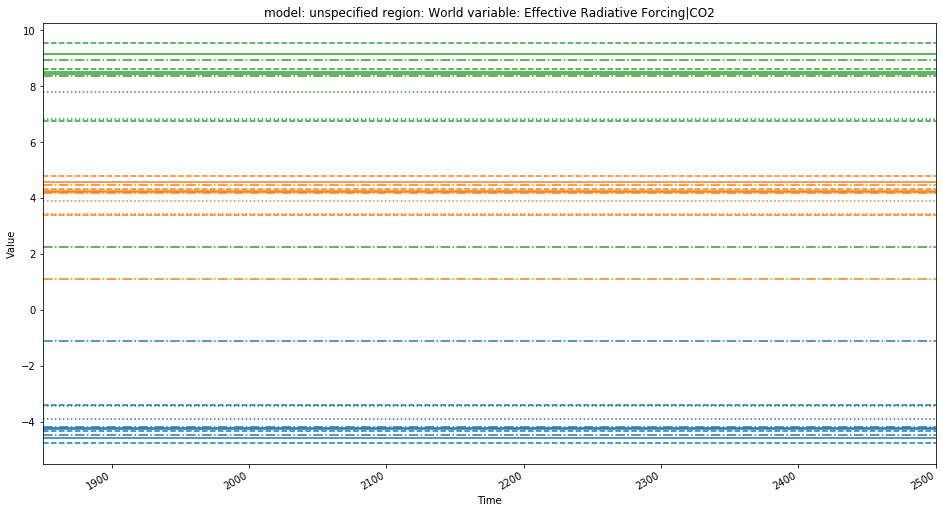

In [116]:
ax = results.filter(scenario="abrupt-*").filter(variable="*Forcing*|CO2").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)

(-4, 15)

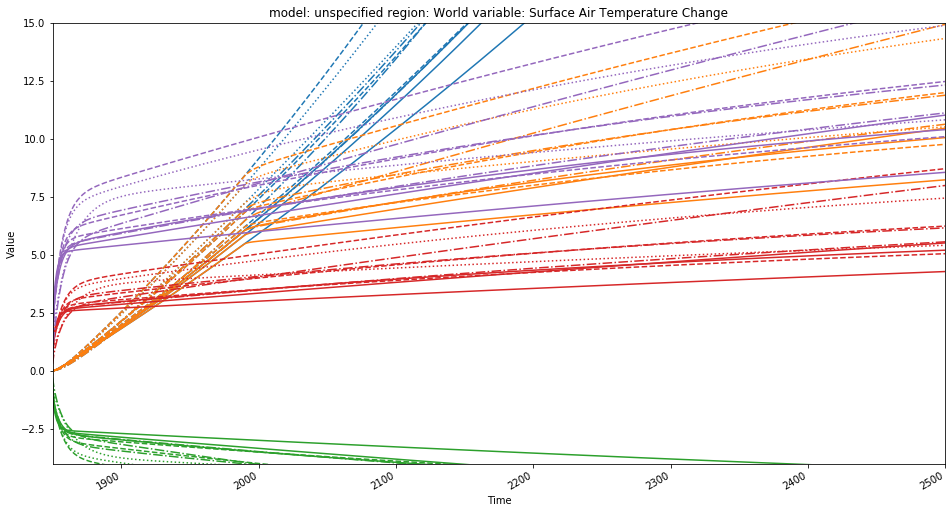

In [121]:
ax = results.filter(scenario=["ssp*", "historical", "piControl"], keep=False).filter(variable="*Temperature*").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])

(-4, 15)

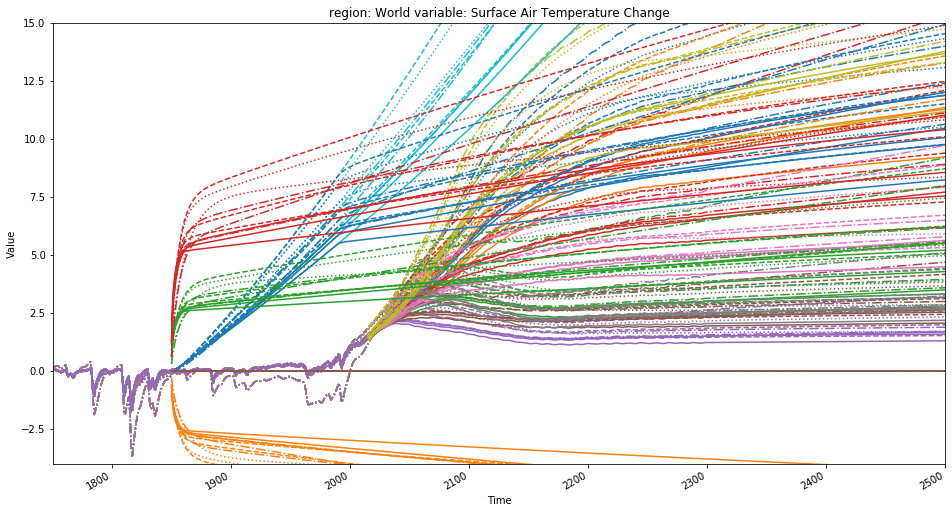

In [122]:
ax = results.filter(variable="*Temperature*").line_plot(
    figsize=(16, 9), linestyle="climatemodel", color="scenario", legend=False
)
ax.set_ylim([-4, 15])